# Correlação de Pearson – detecção dinâmica de colunas numéricas
Este notebook resolve o erro **KeyError** ao tentar acessar colunas que não
existem no DataFrame (`df[numeric_cols]`). Ele faz:
1. Carregamento do dataset `uf_votos_ideologia_socioeco_2022.csv` (ajuste caminho se necessário).
2. Verificação de quais colunas da lista-alvo realmente existem no arquivo.
3. Conversão segura de strings com vírgula em `float`.
4. Cálculo das correlações de Pearson e visualização.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

csv_path = Path('data_lake/processed/uf_votos_ideologia_socioeco_2022.csv')  

## 1. Carregar CSV

In [2]:
df = pd.read_csv(csv_path)
print('Colunas encontradas:', list(df.columns))
df.head()

Colunas encontradas: ['UF', 'PIB_milhoes', 'PIB_per_capita', 'IDHM_2021', 'Esperanca_vida_anos', 'Mort_infantil_pmil', 'Gini', 'Analfabetismo_perc', 'centro', 'centro-direita', 'centro-esquerda', 'direita', 'esquerda', 'total_votos', 'centro_perc', 'centro-direita_perc', 'centro-esquerda_perc', 'direita_perc', 'esquerda_perc']


,UF,PIB_milhoes,PIB_per_capita,IDHM_2021,Esperanca_vida_anos,Mort_infantil_pmil,Gini,Analfabetismo_perc,centro,centro-direita,centro-esquerda,direita,esquerda,total_votos,centro_perc,centro-direita_perc,centro-esquerda_perc,direita_perc,esquerda_perc
0,AC,23676,28525,"0,71",75.3,15.5,0.52,12.13,20122,3269,12314,275905,129307,440917,4.563671,0.741409,2.792816,62.575269,29.326835
1,AL,76066,24322,"0,684",73.3,13.8,0.50,17.66,67411,13133,43542,624674,975457,1724217,3.909659,0.761679,2.525320,36.229431,56.573912
2,AM,145140,36827,"0,7",73.0,16.0,0.51,6.94,87060,22214,44527,881838,1021037,2056676,4.233044,1.080092,2.164998,42.876856,49.645010
3,AP,23614,32194,"0,688",75.0,18.1,0.53,6.47,27497,4191,14670,188042,197761,432161,6.362675,0.969777,3.394568,43.512024,45.760955
4,BA,402647,28483,"0,691",74.5,14.0,0.51,12.60,197305,76651,217224,2053250,5878578,8423008,2.342453,0.910019,2.578936,24.376683,69.791908


## 2. Definir lista-alvo e filtrar apenas colunas existentes

In [3]:
target_numeric = [
    'PIB_per_capita','PIB_milhoes','IDHM_2021','Gini',
    'Esperanca_vida_anos','Mort_infantil_pmil','Analfabetismo_perc','IPCA_2022_perc',
    'esquerda_perc','centro-esquerda_perc','centro_perc','centro-direita_perc','direita_perc'
]

numeric_cols = [c for c in target_numeric if c in df.columns]
print('Colunas numéricas detectadas:', numeric_cols)

Colunas numéricas detectadas: ['PIB_per_capita', 'PIB_milhoes', 'IDHM_2021', 'Gini', 'Esperanca_vida_anos', 'Mort_infantil_pmil', 'Analfabetismo_perc', 'esquerda_perc', 'centro-esquerda_perc', 'centro_perc', 'centro-direita_perc', 'direita_perc']


## 3. Converter vírgulas para ponto e forçar float

In [4]:
for col in numeric_cols:
    df[col] = (df[col].astype(str)
                      .str.replace(',', '.', regex=False)
                      .str.replace('%', '', regex=False))
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Verificar dtypes
df[numeric_cols].dtypes

PIB_per_capita            int64
PIB_milhoes               int64
IDHM_2021               float64
Gini                    float64
Esperanca_vida_anos     float64
Mort_infantil_pmil      float64
Analfabetismo_perc      float64
esquerda_perc           float64
centro-esquerda_perc    float64
centro_perc             float64
centro-direita_perc     float64
direita_perc            float64
dtype: object

## 4. Criar blocos voto esquerda/direita

In [5]:
df['left_vote'] = df.get('esquerda_perc', 0) + df.get('centro-esquerda_perc', 0)
df['right_vote'] = df.get('direita_perc', 0) + df.get('centro-direita_perc', 0)

## 5. Calcular correlações

In [6]:
variables = [v for v in ['PIB_per_capita','PIB_milhoes','IDHM_2021','Gini',
                         'Esperanca_vida_anos','Mort_infantil_pmil','Analfabetismo_perc','IPCA_2022_perc'] if v in df.columns]

corr_rows = []
for var in variables:
    corr_right = df[[var, 'right_vote']].corr().iloc[0, 1]
    corr_left = df[[var, 'left_vote']].corr().iloc[0, 1]
    corr_rows.append({'variavel': var, 'corr_direita': corr_right, 'corr_esquerda': corr_left})

corr_df = pd.DataFrame(corr_rows).sort_values('corr_direita', key=lambda s: s.abs(), ascending=False)
corr_df

,variavel,corr_direita,corr_esquerda
6,Analfabetismo_perc,-0.757748,0.779423
0,PIB_per_capita,0.541687,-0.563596
2,IDHM_2021,0.425039,-0.441600
3,Gini,-0.416709,0.406385
4,Esperanca_vida_anos,0.380523,-0.401964
5,Mort_infantil_pmil,-0.165495,0.171547
1,PIB_milhoes,0.120746,-0.150453


## 6. Heatmap

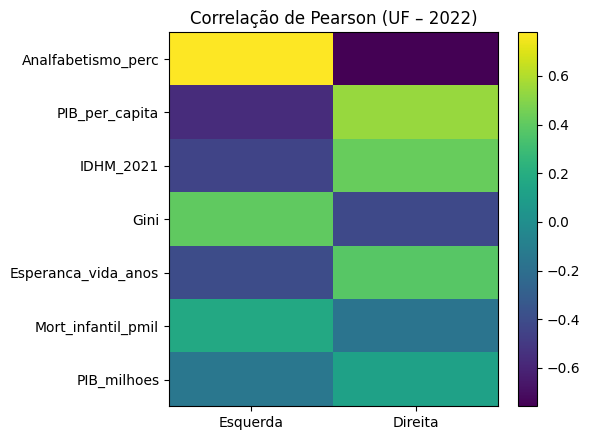

In [7]:
fig, ax = plt.subplots(figsize=(6, len(corr_df)*0.5+1))
heat_data = corr_df[['corr_esquerda', 'corr_direita']].to_numpy()
img = ax.imshow(heat_data, aspect='auto', cmap='viridis')
ax.set_xticks([0,1]); ax.set_xticklabels(['Esquerda','Direita'])
ax.set_yticks(range(len(corr_df))); ax.set_yticklabels(corr_df['variavel'])
plt.colorbar(img, ax=ax)
plt.title('Correlação de Pearson (UF – 2022)')
plt.tight_layout()
plt.show()